# Assignment 2
## Morteza Aghajanzadeh

In [23]:
import wrds
import pandas as pd
import numpy as np
import json 
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

## 0. Data Cleaning

In [ ]:
# Connect to WRDS database
try:
    with open('wrds_credential.txt') as f: 
        data = f.read() 
    credential = json.loads(data)
    wrds_db = wrds.Connection(wrds_username=credential['user_name'], wrds_password=credential['password'])
except:
    print("Could not connect to WRDS database. Enter your username and password to connect to WRDS database:")
    wrds_db = wrds.Connection()

In [ ]:
## Get CRSP data
# Get the monthly stock price data
wrds_db.list_tables(library='crsp')
wrds_db.describe_table(library='crsp', table='msf')
monthly_price_data = wrds_db.get_table(library='crsp', table='msf', columns=['permno', 'date', 'prc', 'ret', 'shrout', 'hexcd'])

# Get the linking file
wrds_db.describe_table(library='crsp', table='msenames')
linking_table = wrds_db.get_table(library='crsp', table='msenames',columns=['permno', 'exchcd', 'shrcd'])
monthly_price_data = monthly_price_data.merge(linking_table, on='permno', how='left')

# Get the linking file with Compustat
linking_table = wrds_db.raw_sql(
    """select gvkey, lpermno as permno
    from crsp_a_ccm.ccmxpf_lnkhist
      """)
linking_table.dropna(inplace=True)
linking_table.reset_index(drop=True, inplace=True)
monthly_price_data = monthly_price_data.merge(linking_table, on='permno', how='left')
monthly_price_data.sample(5)

In [4]:
## Clean the monthly stock price and add the required variables
# Keep only NYSE, AMEX, and NASDAQ
monthly_price_data = monthly_price_data.loc[monthly_price_data['hexcd'] <= 3] 

# Keep only ordinary common shares
monthly_price_data = monthly_price_data.loc[monthly_price_data['shrcd'].isin([10,11])] 

# Change the column type
monthly_price_data['date'] = pd.to_datetime(monthly_price_data['date'])
monthly_price_data['prc'] = monthly_price_data['prc'].astype(float)
monthly_price_data['shrout'] = monthly_price_data['shrout'].astype(float)
monthly_price_data['ret'] = monthly_price_data['ret'].astype(float)

# Add the required variables
monthly_price_data['year'] = monthly_price_data['date'].dt.year
monthly_price_data['month'] = monthly_price_data['date'].dt.month

# Change the year for the first half of the year
monthly_price_data.loc[monthly_price_data.month <= 6, 'year'] = monthly_price_data.loc[monthly_price_data.month <= 6]['year'] - 1 
monthly_price_data['year'] = monthly_price_data['year'].astype(int)
monthly_price_data.drop(columns=['month'], inplace=True)
monthly_price_data.sort_values(by=['permno', 'year'], inplace=True)

# Identify the error in the price data 
monthly_price_data['prc_flag'] = monthly_price_data['prc'].apply(lambda x: 1 if x <= 0 else 0)
monthly_price_data['prc'] = monthly_price_data['prc'].abs()

# Calculate the market capitalization
monthly_price_data['mcap'] = monthly_price_data['prc'] * monthly_price_data['shrout'] / 1e6
monthly_price_data.reset_index(drop=True, inplace=True)
monthly_price_data.sample(5)

,permno,date,prc,ret,shrout,hexcd,exchcd,shrcd,gvkey,year,prc_flag,mcap
9903788,25590,1970-08-31,23.00,0.076023,5094.0,1,1,11,007733,1970,0,0.117162
554043,10442,1997-01-31,10.50,0.076923,4345.0,3,3,11,012331,1996,0,0.045623
15917049,56630,1990-02-28,17.75,0.044118,13799.0,3,3,11,007761,1989,0,0.244932
22602675,82975,1987-04-30,15.25,-0.052308,936.0,3,3,11,011507,1986,0,0.014274
25229879,89790,2018-03-29,7.21,-0.174112,228421.0,2,3,11,006936,2017,0,1.646915


In [5]:
## Get Compustat data and clean it
book_wrds = wrds_db.raw_sql(
    """select GVKEY, BKVLPS, FYEAR
    from comp.funda
      """).sort_values(by='fyear')
book_wrds.dropna(inplace=True)
book_wrds.reset_index(drop=True, inplace=True)
book_wrds['year'] = book_wrds['fyear'].astype(int)
book_wrds.drop(columns=['fyear'], inplace=True)

In [6]:
## Get the Moody's moody_data from French's website
# Load the data
moody_data = pd.read_csv('Data/DFF_BE_With_Nonindust.csv')
moody_data.replace(-99.9900, np.nan, inplace=True)

# rename the columns
moody_data.rename(
    columns={
        'Column2': 'CRSP_Permno',
        'Column3': 'First_Moody_Year',
        'Column4': 'Last_Moody_Year',
        }, inplace=True)

# Melt the data to have the Panel data
moody_data = moody_data.melt(id_vars=['CRSP_Permno', 'First_Moody_Year', 'Last_Moody_Year']).sort_values(by=['CRSP_Permno', 'First_Moody_Year', 'Last_Moody_Year']).dropna().drop('variable', axis=1)
moody_data['year'] = moody_data.groupby(['CRSP_Permno', 'First_Moody_Year', 'Last_Moody_Year']).cumcount()
moody_data['year'] = moody_data['year'] + moody_data['First_Moody_Year']
moody_data.drop(['First_Moody_Year', 'Last_Moody_Year'], axis=1, inplace=True)

# Rename the columns
moody_data.rename(columns={
    'CRSP_Permno': 'permno',
    'value': 'BE'}, inplace=True)
# Scale the book equity
moody_data['BE'] = moody_data['BE'].astype(float)/1e3
moody_data.sample(5)

,permno,BE,year
55700,10989,0.154820,1957
0,10006,0.067743,1926
18405,15544,0.003012,1936
36,10401,1.108320,1926
48616,12087,0.030679,1953


In [7]:
## Merge the data
# Merge the CRSP data with the Moody's data
df = monthly_price_data.merge(moody_data, on=['permno', 'year'], how='left')

# Merge the merged data with the book data
df = df.merge(book_wrds, on=['gvkey', 'year'], how='left').drop(columns=['gvkey'])

# Calculate the book equity based on the Compustat data
df['bkvlps'] = df['bkvlps'].astype(float)
df['bkvlps'] = df['bkvlps'] * df['shrout'] / 1e6

# Assume that the book equity is the Compustat data and fill the missing values with the Moody's data
df['BookEquity'] = df['bkvlps']
# Fill the missing values
df['BookEquity'] = df['BookEquity'].fillna(df['BE'])

# Save the data
df.to_csv('Out/monthly_return_book_value.csv', index=False)
df.describe()

,permno,date,prc,ret,shrout,hexcd,exchcd,shrcd,year,prc_flag,mcap,BE,bkvlps,BookEquity
count,2.617874e+07,26178735,2.496176e+07,2.483918e+07,2.608291e+07,2.617874e+07,2.617874e+07,2.617874e+07,2.617874e+07,2.617874e+07,2.496176e+07,2.650611e+06,2.108396e+07,2.328800e+07
mean,4.607342e+04,1989-09-13 06:53:23.153429248,6.764473e+01,1.184360e-02,6.476894e+04,1.950540e+00,2.007293e+00,1.082722e+01,1.988665e+03,1.562762e-01,2.917321e+00,1.091765e-01,3.301800e+01,2.990168e+01
min,1.000000e+04,1925-12-31 00:00:00,1.050000e-02,-9.956900e-01,0.000000e+00,1.000000e+00,-2.000000e+00,1.000000e+01,1.925000e+03,0.000000e+00,0.000000e+00,-4.896360e-01,-1.603667e+05,-1.603667e+05
25%,1.964900e+04,1977-10-31 00:00:00,5.300000e+00,-6.160000e-02,2.837000e+03,1.000000e+00,1.000000e+00,1.100000e+01,1.977000e+03,0.000000e+00,2.086025e-02,1.117600e-02,1.182486e-02,1.143490e-02
50%,4.069400e+04,1992-06-30 00:00:00,1.547000e+01,0.000000e+00,9.406000e+03,2.000000e+00,2.000000e+00,1.100000e+01,1.991000e+03,0.000000e+00,9.935400e-02,2.927000e-02,7.054746e-02,6.098151e-02
75%,7.632900e+04,2005-03-31 00:00:00,3.187000e+01,6.746000e-02,3.375200e+04,3.000000e+00,3.000000e+00,1.100000e+01,2.004000e+03,0.000000e+00,6.556877e-01,8.482600e-02,4.199657e-01,3.548748e-01
max,9.343600e+04,2023-12-29 00:00:00,5.467250e+05,2.400000e+01,2.920640e+07,3.000000e+00,3.300000e+01,1.100000e+01,2.023000e+03,1.000000e+00,3.071345e+03,8.106300e+00,1.021732e+07,1.021732e+07
std,2.799543e+04,NaN,3.350797e+03,1.792260e-01,3.303505e+05,9.516356e-01,1.961682e+00,3.780590e-01,2.119084e+01,3.631170e-01,1.956020e+01,2.905744e-01,1.047523e+04,9.967215e+03


In [8]:
## Clean up the workspace
wrds_db.close()
del monthly_price_data, linking_table, book_wrds, moody_data

In [25]:
## Additional variables and cleaning
# Add the B/M ratio
df['B/M'] = df.BookEquity/df.mcap
df['B/M'] = df['B/M'].replace([np.inf, -np.inf], np.nan)

# Change the type of columns
df['date'] = pd.to_datetime(df['date'])
df['month'] = df.date.dt.month
df['yearMonth'] = df.date.dt.to_period('M')

# Additional cleaning
df.drop_duplicates(subset=['date', 'permno'], inplace=True)
df.drop(df.loc[df.prc_flag == 1].index, inplace=True) # French state that they only used the good price data, so we will do the same and drop the bad price data

In [26]:
## Create the selection of annual portfolio and the end of June

# Based on French's description, we need to sort the stocks based on the market capitalization at the end of December
# Then, we will use the end of June market capitalization to calculate the book to market ratio
# We will use the end of June to calculate the B/M ratio
# We will use the end of December to sort the stocks
portfolio_selection = pd.DataFrame()
portfolio_selection = df.loc[df.month.isin([7,12])].copy()
# Drop the missing market capitalization
portfolio_selection['mcap_flag'] = portfolio_selection.groupby(['permno', 'year'])['mcap'].transform(lambda x: 1 if x.isna().sum() > 0 else 0)
portfolio_selection = portfolio_selection.loc[portfolio_selection.mcap_flag == 0].copy()

# mapping the market capitalization at the end of December to the end of June to do the double sorting
mapping_dict = dict(zip(portfolio_selection.loc[portfolio_selection.month == 12].set_index(['permno', 'year']).index, portfolio_selection.loc[portfolio_selection.month == 12].mcap))
portfolio_selection.drop(portfolio_selection[portfolio_selection.month == 12].index, inplace=True)
portfolio_selection['mcap'] = portfolio_selection.set_index(['permno', 'year']).index.map(mapping_dict)
portfolio_selection.dropna(subset=['mcap'], inplace=True)


## 1. Compute the characteristic

In [27]:
## Calculate the B/M breakpoints
portfolio_selection = portfolio_selection.loc[portfolio_selection.month == 7].dropna(subset=['B/M','mcap']).copy()
portfolio_selection.drop_duplicates(subset=['permno', 'year'], inplace=True)
plot_portfolio_selection = portfolio_selection.copy()
portfolio_selection = portfolio_selection.loc[portfolio_selection['B/M'] > 0]
High_threshold = portfolio_selection[(portfolio_selection.hexcd == 1)].groupby('year')['B/M'].quantile(0.7).to_dict()
Low_threshold = portfolio_selection[(portfolio_selection.hexcd == 1)].groupby('year')['B/M'].quantile(0.3).to_dict()

In [28]:
## Load the Fama-French 3 breakpoints
raw_df_breakpoint_FF = pd.read_csv('Data/BE-ME_Breakpoints.csv')
raw_df = raw_df_breakpoint_FF[['year','<=0',">0"]].copy().rename(columns={'<=0':'negative', '>0':'positive'})
raw_df['year'] = raw_df['year'].astype(int)
raw_df['data'] = 'FF'
df_breakpoint_FF = raw_df_breakpoint_FF[['year','0.3','0.7']].copy()
df_breakpoint_FF.columns = ['year','Growth','Value']
df_breakpoint_FF['year'] = df_breakpoint_FF['year'].astype(int)
df_breakpoint_FF = df_breakpoint_FF.melt(id_vars='year', value_vars=['Growth', 'Value'], var_name='Threshold', value_name='B/M').sort_values(by=['year', 'Threshold']).reset_index(drop=True)
df_breakpoint_FF['calculation'] = 'FF'

C:\Users\SE.5203\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SE.5203\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


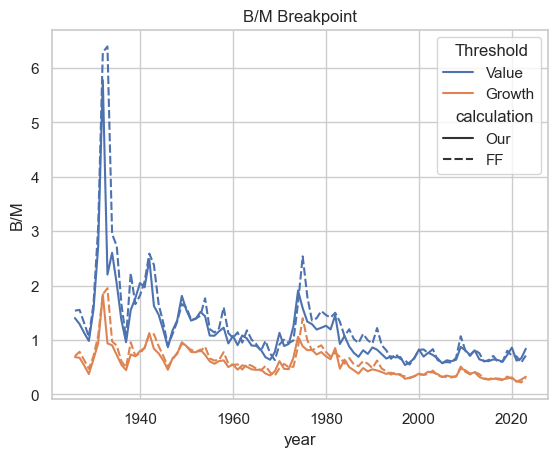

In [36]:
## Create the plot
pd.option_context('mode.use_inf_as_na', True)
df_breakpoint = pd.DataFrame({'High_threshold': High_threshold, 'Low_threshold': Low_threshold})
df_breakpoint = df_breakpoint.reset_index()
df_breakpoint.rename(columns={'index': 'year'}, inplace=True)
df_breakpoint = df_breakpoint.melt(id_vars='year', value_vars=['High_threshold', 'Low_threshold'], var_name='Threshold', value_name='B/M')
df_breakpoint['Threshold'] = df_breakpoint.Threshold.map({'High_threshold': 'Value', 'Low_threshold': 'Growth'})
df_breakpoint['calculation'] = 'Our'
df_breakpoint = pd.concat([df_breakpoint, df_breakpoint_FF], ignore_index=True)
sns.set(style="whitegrid")
ax = sns.lineplot(x="year", y="B/M", hue="Threshold", style="calculation", data=df_breakpoint)
ax.set_title('B/M Breakpoint')
plt.savefig('Out/B_M_Breakpoint.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Generate data set of stock returns

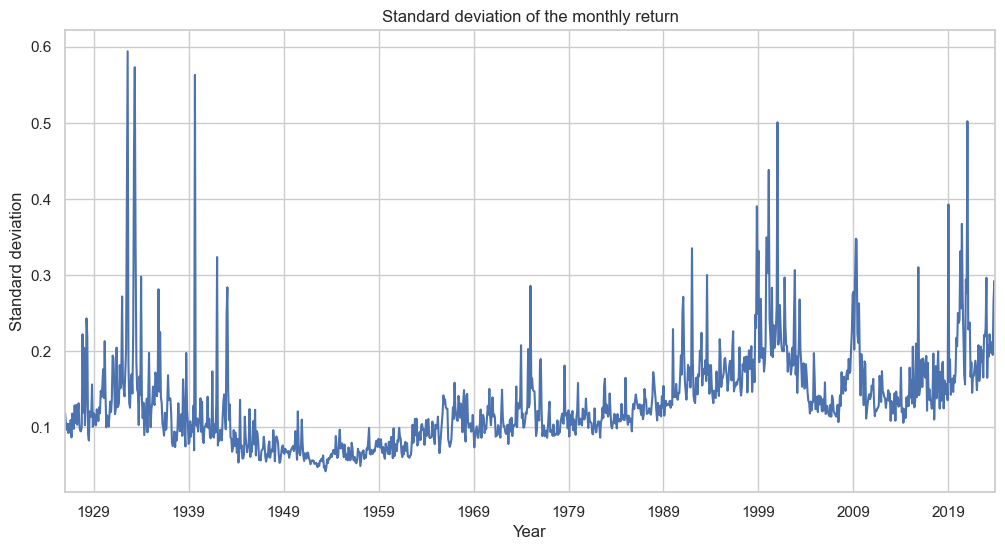

In [39]:
## Monthly return
monthly_return_df = pd.DataFrame()
monthly_return_df = df.dropna(subset=['mcap','ret'])[['permno','hexcd','year','ret','yearMonth','month','mcap','B/M']].copy()
# Calculate the high market capitalization for winterizing at the NYSE 80th percentile
mapping_dict = monthly_return_df.loc[monthly_return_df.hexcd == 1].groupby('yearMonth').mcap.quantile(0.8).to_dict()
monthly_return_df['high_cap'] = monthly_return_df.yearMonth.map(mapping_dict)

# Plot the standard deviation of the monthly return 
plt.figure(figsize=(12, 6))
monthly_return_df.groupby('yearMonth').ret.std().plot() 
plt.title('Standard deviation of the monthly return')
plt.xlabel('Year')
plt.ylabel('Standard deviation')
plt.savefig('Out/Standard_deviation_monthly_return.png', dpi=300, bbox_inches='tight')

## 3. Generate the factor returns

In [40]:
## Portfolio formation at the end of June

# We use the portfolio_selection dataframe to form the portfolio which is the dataframe that we used to calculate the B/M breakpoints at the end of June and market capitalization at the end of December at the NYSE, AMEX, and NASDAQ

# Based on French's description, we need to find the breakpoint of market capitalization  from the NYSE stocks 
# Based on CRSP, hexcd = 1 is the NYSE stocks

# High B/M and Big
High_Big_portfolio = portfolio_selection.groupby('year')[['permno','B/M','mcap','hexcd']].apply(lambda x: x.loc[(x['B/M'] > x['B/M'].quantile(0.7))&(x.mcap >= x[x.hexcd == 1].mcap.quantile(0.5))].permno.tolist()).to_dict()
High_Big_portfolio = {(i,j): 1 for i in High_Big_portfolio for j in High_Big_portfolio[i]}

# Low B/M and Big
Low_Big_portfolio = portfolio_selection.groupby('year')[['permno','B/M','mcap','hexcd']].apply(lambda x: x.loc[(x['B/M'] <= x['B/M'].quantile(0.3))&(x.mcap >= x[x.hexcd == 1].mcap.quantile(0.5))].permno.tolist()).to_dict()
Low_Big_portfolio = {(i,j): 1 for i in Low_Big_portfolio for j in Low_Big_portfolio[i]}

# High B/M and Small
High_Small_portfolio = portfolio_selection.groupby('year')[['permno','B/M','mcap','hexcd']].apply(lambda x: x.loc[(x['B/M'] > x['B/M'].quantile(0.7))&(x.mcap < x[x.hexcd == 1].mcap.quantile(0.5))].permno.tolist()).to_dict()
High_Small_portfolio = {(i,j): 1 for i in High_Small_portfolio for j in High_Small_portfolio[i]}

# Low B/M and Small
Low_Small_portfolio = portfolio_selection.groupby('year')[['permno','B/M','mcap','hexcd']].apply(lambda x: x.loc[(x['B/M'] <= x['B/M'].quantile(0.3))&(x.mcap < x[x.hexcd == 1].mcap.quantile(0.5))].permno.tolist()).to_dict()
Low_Small_portfolio = {(i,j): 1 for i in Low_Small_portfolio for j in Low_Small_portfolio[i]}

In [41]:
## Now we have the portfolio formation at the end of June, we will calculate the monthly return of the portfolio

# We will use the monthly_return_df dataframe to calculate the monthly return of the portfolio
# For each portfolio, we will create a separate dataframe
monthly_return_df['BH'] = monthly_return_df.set_index(['year','permno']).index.map(High_Big_portfolio)
monthly_return_df['SH'] = monthly_return_df.set_index(['year','permno']).index.map(High_Small_portfolio)
monthly_return_df['BL'] = monthly_return_df.set_index(['year','permno']).index.map(Low_Big_portfolio)
monthly_return_df['SL'] = monthly_return_df.set_index(['year','permno']).index.map(Low_Small_portfolio)
monthly_return_df[['BH','SH','BL','SL']] = monthly_return_df[['BH','SH','BL','SL']].fillna(0)

bh_df, sh_df, bl_df, sl_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
bh_df = monthly_return_df.loc[monthly_return_df.BH == 1].copy()
sh_df = monthly_return_df.loc[monthly_return_df.SH == 1].copy()
bl_df = monthly_return_df.loc[monthly_return_df.BL == 1].copy()
sl_df = monthly_return_df.loc[monthly_return_df.SL == 1].copy()

In [44]:
## Function to calculate the portfolio return based on the value weight
# Also calculate the portfolio return based on the capped-value weighting
def get_portfolio_return(df,weight):
    if weight == 'equal':
        return df.groupby('yearMonth').ret.mean()
    elif weight == 'capped_value':
        df.loc[df.mcap > df.high_cap, 'mcap'] = df.loc[df.mcap > df.high_cap].high_cap
        df['mweight'] = df.groupby('yearMonth')['mcap'].transform(lambda x: x/sum(x))
    else:
        df['mweight'] = df.groupby('yearMonth')[weight].transform(lambda x: x/sum(x))
    df['w_ret'] = df['mweight']*df['ret']
    return df.groupby('yearMonth').w_ret.sum()
return_df = pd.DataFrame()
return_df['BH'] = get_portfolio_return(bh_df,weight = 'mcap')
return_df['SH'] = get_portfolio_return(sh_df,weight = 'mcap')
return_df['BL'] = get_portfolio_return(bl_df,weight = 'mcap')
return_df['SL'] = get_portfolio_return(sl_df,weight = 'mcap')
return_df.reset_index(inplace=True)
return_df['yearMonth'] = return_df['yearMonth'].dt.to_timestamp()
# Calculate the HML return
return_df['HML'] = 0.5 * (return_df['BH'] + return_df['SH'] - return_df['BL'] - return_df['SL'])
# Calculate the cumulative return
return_df['cum_HML'] = ((1+return_df['HML']).cumprod()-1)

C:\Users\SE.5203\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SE.5203\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SE.5203\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

,HML_our,HML_ff
HML_our,1.000000,0.877186
HML_ff,0.877186,1.000000


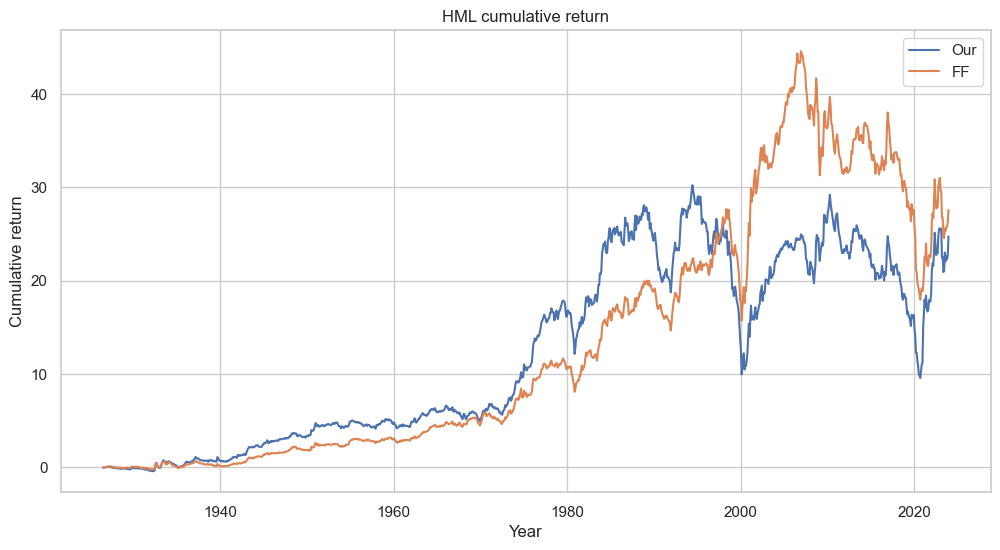

In [48]:
## Load the Fama-French HML return and compare it with our HML return
# Load the Fama-French HML return
ff_df = pd.read_csv('Data/F-F_Research_Data_Factors.csv')
ff_df.iloc[:,1:] = ff_df.iloc[:,1:]/100
ff_df['yearMonth'] = pd.to_datetime(ff_df['yearMonth'], format='%Y%m')
ff_df['cum_HML'] = ((1+ff_df['HML']).cumprod()-1)

# Plot the HML return
plt.figure(figsize=(12, 6))
sns.lineplot(data=return_df, x='yearMonth', y='cum_HML', label='Our')
sns.lineplot(data=ff_df, x='yearMonth', y='cum_HML', label='FF')
plt.title('HML cumulative return')
plt.xlabel('Year')
plt.ylabel('Cumulative return')
plt.savefig('Out/HML_cumulative_return.png', dpi=300, bbox_inches='tight')

# calculate the correlation between our HML return and FF HML return
return_df[['yearMonth','HML','cum_HML']].merge(ff_df[['yearMonth','HML','cum_HML']], on='yearMonth', suffixes=('_our', '_ff'))[['HML_our','HML_ff']].corr()

###

## 4. Compare factor returns

In [49]:
## Caclulate the equal-weighted and capped-value-weighted return
# Calculate the equal-weighted return
return_df['BH_equal'] = get_portfolio_return(bh_df, weight='equal').reset_index(drop=True)
return_df['SH_equal'] = get_portfolio_return(sh_df, weight='equal').reset_index(drop=True)
return_df['BL_equal'] = get_portfolio_return(bl_df, weight='equal').reset_index(drop=True)
return_df['SL_equal'] = get_portfolio_return(sl_df, weight='equal').reset_index(drop=True)
return_df['HML_equal'] = 0.5 * (return_df['BH_equal'] + return_df['SH_equal'] - return_df['BL_equal'] - return_df['SL_equal'])
return_df['cum_HML_equal'] = ((1+return_df['HML_equal']).cumprod()-1)

# Calculate the capped-value-weighted return
return_df['BH_capped_value'] = get_portfolio_return(bh_df, weight='capped_value').reset_index(drop=True)
return_df['SH_capped_value'] = get_portfolio_return(sh_df, weight='capped_value').reset_index(drop=True)
return_df['BL_capped_value'] = get_portfolio_return(bl_df, weight='capped_value').reset_index(drop=True)
return_df['SL_capped_value'] = get_portfolio_return(sl_df, weight='capped_value').reset_index(drop=True)
return_df['HML_capped_value'] = 0.5 * (return_df['BH_capped_value'] + return_df['SH_capped_value'] - return_df['BL_capped_value'] - return_df['SL_capped_value'])
return_df['cum_HML_capped_value'] = ((1+return_df['HML_capped_value']).cumprod()-1)

In [50]:
## Load JKP data and compare it with our HML return
# Load the JKP HML return
jkp_ew = pd.read_csv('Data/JKP/[usa]_[be_me]_[monthly]_[ew].csv')[['date','ret']]
jkp_ew['date'] = pd.to_datetime(jkp_ew['date'])
jkp_vw = pd.read_csv('Data/JKP/[usa]_[be_me]_[monthly]_[vw].csv')[['date','ret']]
jkp_vw['date'] = pd.to_datetime(jkp_vw['date'])
jkp_vw_cap = pd.read_csv('Data/JKP/[usa]_[be_me]_[monthly]_[vw_cap].csv')[['date','ret']]
jkp_vw_cap['date'] = pd.to_datetime(jkp_vw_cap['date'])

# merge the different JKP HML return
jkp_return_df = jkp_ew.merge(jkp_vw, on='date', suffixes=('_ew', '_vw')).merge(jkp_vw_cap, on='date').rename(columns={'ret':'ret_vw_cap'})

# Calculate the cumulative return
jkp_return_df['cum_ew'] = ((1+jkp_return_df['ret_ew']).cumprod()-1)
jkp_return_df['cum_vw'] = ((1+jkp_return_df['ret_vw']).cumprod()-1)
jkp_return_df['cum_vw_cap'] = ((1+jkp_return_df['ret_vw_cap']).cumprod()-1)

C:\Users\SE.5203\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SE.5203\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SE.5203\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

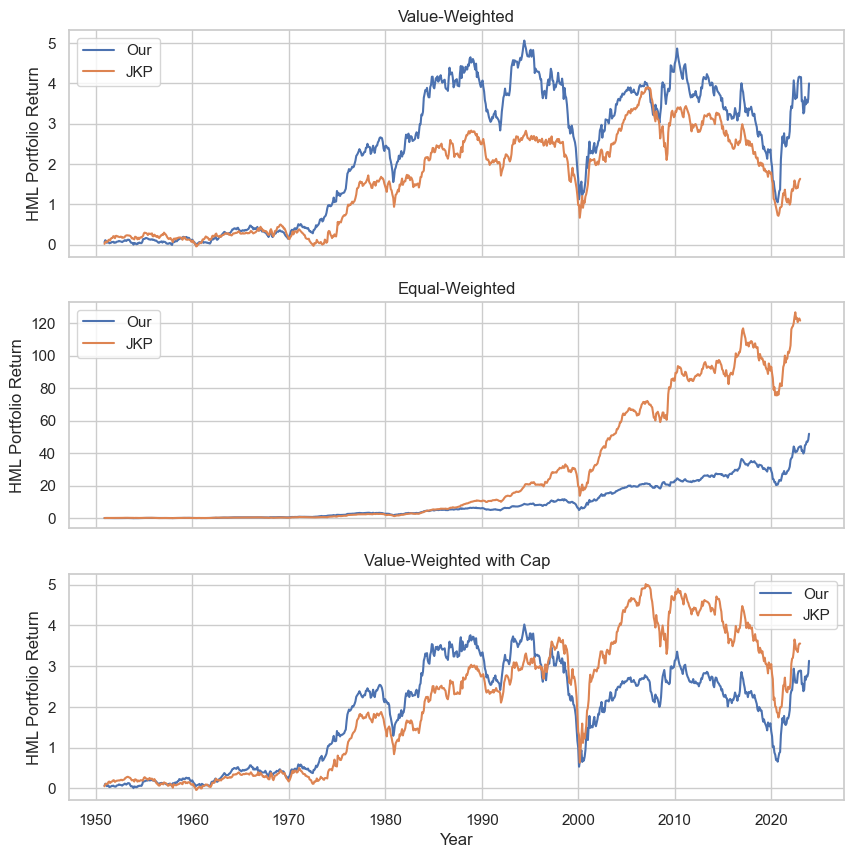

In [53]:
## Plot the HML return
# bring the HML return to the same start date as JKP HML return
return_df['cum_HML_jkp'] = return_df['HML']
return_df.loc[return_df.yearMonth < jkp_return_df.date.min(), 'cum_HML_jkp'] = np.nan
return_df['cum_HML_jkp'] = ((1+return_df['cum_HML_jkp']).cumprod()-1)

return_df['cum_HML_equal_jkp'] = return_df['HML_equal']
return_df.loc[return_df.yearMonth < jkp_return_df.date.min(), 'cum_HML_equal_jkp'] = np.nan
return_df['cum_HML_equal_jkp'] = ((1+return_df['cum_HML_equal_jkp']).cumprod()-1)

return_df['cum_HML_capped_value_jkp'] = return_df['HML_capped_value']
return_df.loc[return_df.yearMonth < jkp_return_df.date.min(), 'cum_HML_capped_value_jkp'] = np.nan
return_df['cum_HML_capped_value_jkp'] = ((1+return_df['cum_HML_capped_value_jkp']).cumprod()-1)

# Plot the HML return
fig, ax = plt.subplots(3, sharex=True, figsize=(10,10))
sns.lineplot(data=return_df, x='yearMonth', y='cum_HML_jkp', label='Our', ax=ax[0])
sns.lineplot(data=jkp_return_df, x='date', y='cum_vw', label='JKP', ax=ax[0])
sns.lineplot(data=return_df, x='yearMonth', y='cum_HML_equal_jkp', label='Our', ax=ax[1])
sns.lineplot(data=jkp_return_df, x='date', y='cum_ew', label='JKP', ax=ax[1])
sns.lineplot(data=return_df, x='yearMonth', y='cum_HML_capped_value_jkp', label='Our', ax=ax[2])
sns.lineplot(data=jkp_return_df, x='date', y='cum_vw_cap', label='JKP', ax=ax[2])

# set axis labels
ax[0].set_title('Value-Weighted')
ax[1].set_title('Equal-Weighted')
ax[2].set_title('Value-Weighted with Cap')
ax[0].set_ylabel('HML Portfolio Return')
ax[1].set_ylabel('HML Portfolio Return')
ax[2].set_ylabel('HML Portfolio Return')
ax[2].set_xlabel('Year')
plt.savefig('Out/HML_cumulative_return_JKP.png', dpi=300, bbox_inches='tight')
plt.show()